<a href="https://colab.research.google.com/github/hangjoni/hanoi-food-classifier/blob/master/Food_Classifier_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading required libraries

In [1]:
# loading necessary library
! [ -e /content ] && pip install -Uqq fastbook
! pip install kaggle

import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

# loading kaggle 
creds = ''
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)
from kaggle import *

     |████████████████████████████████| 719 kB 8.6 MB/s 
     |████████████████████████████████| 1.2 MB 47.7 MB/s 
     |████████████████████████████████| 362 kB 62.4 MB/s 
     |████████████████████████████████| 4.4 MB 71.1 MB/s 
     |████████████████████████████████| 212 kB 66.6 MB/s 
     |████████████████████████████████| 1.1 MB 53.7 MB/s 
     |████████████████████████████████| 101 kB 12.9 MB/s 
     |████████████████████████████████| 140 kB 75.4 MB/s 
     |████████████████████████████████| 596 kB 72.4 MB/s 
     |████████████████████████████████| 127 kB 77.8 MB/s 
     |████████████████████████████████| 144 kB 71.1 MB/s 
     |████████████████████████████████| 271 kB 77.3 MB/s 
     |████████████████████████████████| 94 kB 4.3 MB/s 
     |████████████████████████████████| 6.6 MB 45.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10

## Loading data
This is necessary for training. 
Skip if loading pre-trained model

In [4]:
! kaggle datasets download -d vermaavi/food11 

 55% 1.19G/2.17G [00:11<00:09, 107MB/s]
User cancelled operation


Data is a bit weirdly organized. Unzip will unpack data twice, once in the directory directly, once in food-11 folder

In [ ]:
shutil.unpack_archive('/content/food11.zip')

## Data pre-processing
This step needs to be done even if we load a pre-trained model

In [5]:
def labeller(o):
  f = RegexLabeller(fr'.(\d)_.')

  label_map = {
      '0': "Vegetable-Fruit",
      '1': "Dairy product",
      '2': "Dessert",
      '3': "Egg",
      '4': "Fried food",
      '5': "Meat",
      '6': "Noodles-Pasta",
      '7': "Rice",
      '8': "Seafood",
      '9': "Soup"
  }

  return label_map.get(f(o))

foods = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=labeller,
    item_tfms=Resize(256)
)



## Dataloader and Augmentation
Skip these steps if loading pre-trained model

In [6]:
path = Path('/content/food-11')
dls = foods.dataloaders(path)

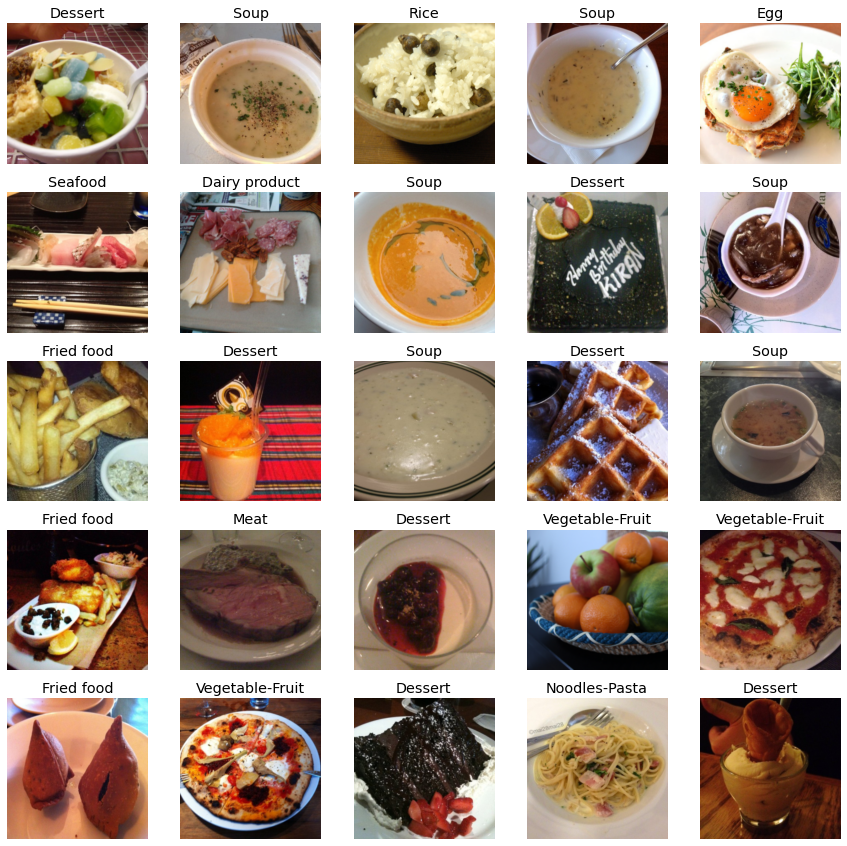

In [7]:
dls.train.show_batch(max_n=25, nrows=5)

TODO: We need to stop the DataLoader from splitting dataset to train and validation set

Data Augmentation

Done with testing, now let's combine both of these transforms. 

We'll crop a bit bigger in RandomResizedCrop so that not too much visibility is lost in later aug_transforms

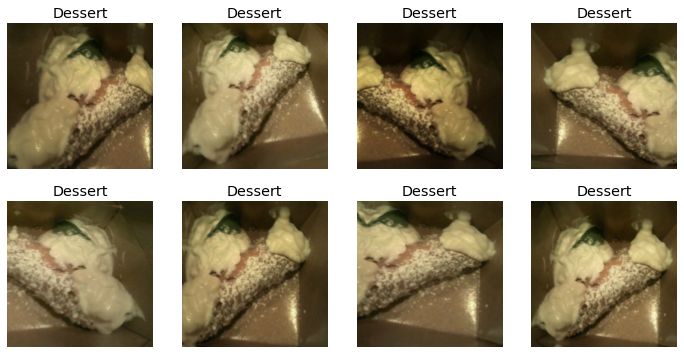

In [8]:
foods = foods.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = foods.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

The above is not seafood, but can be classified as multiple categories (meat, vegetable, rice)

=> This dataset is not accurately labelled and classes have high overlap

=> Need better labelled dataset
=> Then, need to use multi-category model

# First model
We will use transfer learning using resnet18 as the base model.

Resnet18 is a pre-trained convolutional neural network. It has been trained on more than million immages from ImageNet to recognize 1000 object categories. Using transfer learning, we'll leverage the head of Resnet18 which can recognize lower level image patterns and shape. 

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.208852,0.708721,0.227163,02:29


epoch,train_loss,valid_loss,error_rate,time
0,0.682164,0.461196,0.148438,02:25
1,0.456109,0.396331,0.121394,02:33
2,0.328173,0.314542,0.090745,02:33
3,0.244211,0.300602,0.088942,02:35


9.3% error rate, not very good. 

## Checking top losses

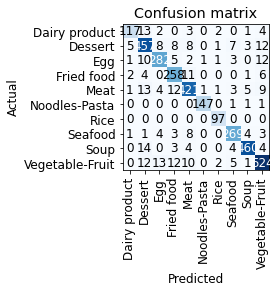

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

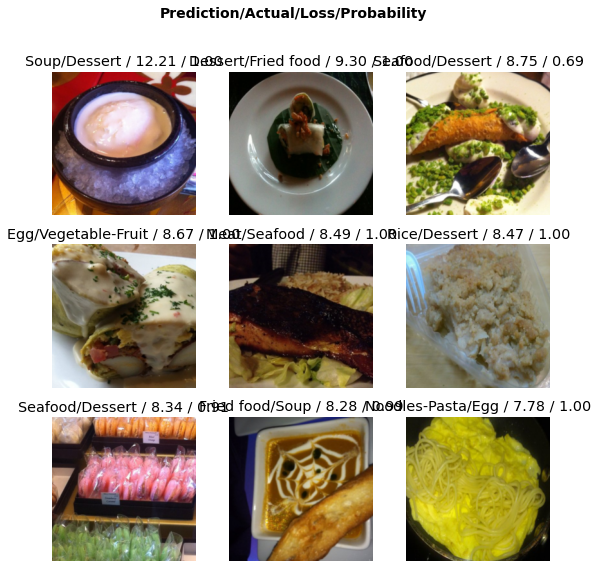

In [ ]:
interp.plot_top_losses(12, nrows=3)

After looking at the top losses, itt seems like labelling problem & multi-class problem as much as a prediction problem

In [ ]:
interp.most_confused(min_val=5)

[('Soup', 'Dessert', 14),
 ('Dairy product', 'Dessert', 13),
 ('Meat', 'Dessert', 13),
 ('Vegetable-Fruit', 'Egg', 13),
 ('Dessert', 'Vegetable-Fruit', 12),
 ('Egg', 'Vegetable-Fruit', 12),
 ('Meat', 'Fried food', 12),
 ('Vegetable-Fruit', 'Dessert', 12),
 ('Vegetable-Fruit', 'Fried food', 12),
 ('Fried food', 'Meat', 11),
 ('Egg', 'Dessert', 10),
 ('Vegetable-Fruit', 'Meat', 10),
 ('Meat', 'Vegetable-Fruit', 9),
 ('Dessert', 'Egg', 8),
 ('Dessert', 'Fried food', 8),
 ('Dessert', 'Meat', 8),
 ('Seafood', 'Meat', 8),
 ('Dessert', 'Seafood', 7),
 ('Fried food', 'Vegetable-Fruit', 6),
 ('Dessert', 'Dairy product', 5),
 ('Egg', 'Fried food', 5),
 ('Meat', 'Soup', 5),
 ('Vegetable-Fruit', 'Seafood', 5)]

Ways to improve our model
- Learning Rate Finder
- Unfreezing and Transfer Learning
- Discriminative Learning Rates
- Selecting the Number of Epochs
- Deeper Archtecture

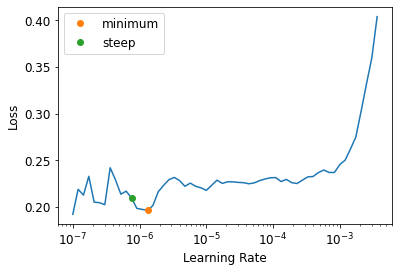

In [ ]:
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

Let's try to rerun the model with the suggested learning rate

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4, base_lr = 3*10-6)

epoch,train_loss,valid_loss,error_rate,time
0,33630.640625,119499808.000000,0.789062,02:25


epoch,train_loss,valid_loss,error_rate,time
0,7286.155762,30706855936.000000,0.954026,02:37
1,2975.076172,813.673523,0.957332,02:35
2,319.410950,116.690094,0.870493,02:30
3,9.181565,1289.213623,0.780950,02:31


That's cool. Our error rate has dropped by 1.5% just by picking the learning rate!


In [ ]:
learn.fine_tune??

Turns out, basically fine_tune just do this:
- freeze the last layer in the model
- fit_one_cycle for a few epochs
- unfreeze
- fit_one_cycle again but with differentiated learning rate

Let's try doing this ourself

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.freeze()
learn.fit_one_cycle(3,3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.898148,0.543103,0.175481,02:16
1,0.594070,0.416510,0.134916,02:12
2,0.481981,0.388351,0.128606,02:15


Then we'll unfreeze the model and find the learning rate

SuggestedLRs(valley=5.248074739938602e-05)

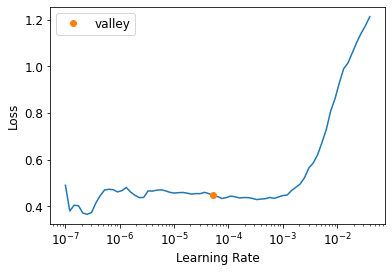

In [ ]:
learn.unfreeze()
learn.lr_find()

We'll then retrain the model with differentiated learning rate

In [ ]:
learn.fit_one_cycle(4, lr_max=(slice(3*1e-6,3*1e-4)))

epoch,train_loss,valid_loss,error_rate,time
0,0.422169,0.357293,0.115986,02:35
1,0.395488,0.334062,0.107873,02:34
2,0.324701,0.320234,0.101863,02:34
3,0.300250,0.311935,0.095553,02:22


Our model has gotten worse as compared to just picking learning rate and use the built-in fine-tune.

Let's plot training and validation loss

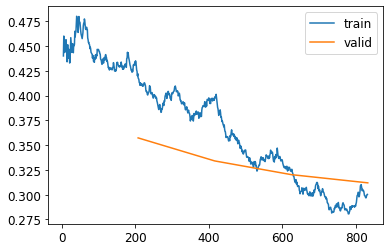

In [ ]:
learn.recorder.plot_loss()

Looks like we have overfit by running for more epochs. We did 3+3 epochs as compared to the learning rate + fine_tune section which did 1+3 epochs

Now let's go back to the previous method and use a deeper model

In [ ]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.907079,0.570270,0.179387,02:14


epoch,train_loss,valid_loss,error_rate,time
0,0.539901,0.403002,0.130709,02:16
1,0.369109,0.302354,0.086238,02:15
2,0.199767,0.233035,0.067007,02:16
3,0.116927,0.225786,0.064303,02:17


With a larger model, error rate is pushed down by another 1+%. Our best effort so far at 6.3% error rate

In [ ]:
learn.recorder.plot_loss()


But again, we've overfit towards the last cycle. Let's try again with less epochs

In [ ]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(2, freeze_epochs=1)

In [ ]:
learn.recorder.plot_loss()

# Save and use pre-trained model

In [ ]:
# Export model 
from google.colab import drive
drive.mount('/content/drive')

learn.export('/content/drive//MyDrive/export.pkl')

In [6]:
# Load pre-trained model
learn_inf = load_learner('/content/drive/MyDrive/food11/export.pkl')

# Multi-category Labelling Model
As we seen above, some of the food images contain elements that belong to different categories. For example, an apple pie image with an apple next to the pie could be categorized as Dessert or Fruit. Ideally, it should be categorized as both.

There are two directions we could explore:
  
1.   With the existing model, we could return the top 3 categories with highest activation
2.   We build a new model for Multi Category Labelling task 





###1. Return top 3 categories

In [7]:
res = learn_inf.predict('/content/drive/MyDrive/food11/pho-quay.jpeg')
res

('Fried food',
 TensorBase(3),
 TensorBase([4.1440e-05, 2.2627e-05, 1.4859e-05, 8.1437e-01, 3.4734e-03, 7.9870e-04, 3.7404e-03, 1.7275e-01, 2.7538e-04, 4.5173e-03]))

In [22]:
def predict_3_cat(learn, img):
  res = learn.predict(img)
  idxs = torch.topk(res[2], 3)
  
  dl = learn.dls.test_dl([img], num_workers=0)
  inp,preds,_,dec_preds = learn.get_preds(dl=dl, with_input=True, with_decoded=True)
  i = getattr(learn.dls, 'n_inp', -1)
  inp = (inp,) if i==1 else tuplify(inp)
  b = inp + tuplify(dec_preds)
  input = batch_to_samples(b, max_n=9)

  f1 = learn_inf.dls.before_batch.decode
  f = learn_inf.dls.after_item.decode
  ff = compose(f1, f, partial(getattr(learn_inf.dls.dataset,'decode',noop), full = True))

  r = []
  for j, k in zip(idxs[0], idxs[1]):
    i = tuple(list([input[0][0],k]))
    input[0] = i
    r.append((input.map(ff)[0][1], j))
  return r

In [25]:
img = '/content/drive/MyDrive/food11/pho-quay.jpeg'
a = predict_3_cat(learn_inf, img)
a

[('Fried food', TensorBase(0.8144)),
 ('Seafood', TensorBase(0.1727)),
 ('Vegetable-Fruit', TensorBase(0.0045))]

Huh food-11 has 10 categories? I just realized haha. This dataset seems increasingly questionable 

###2. Multi-category label
The issue is our dataset is labelled using only single category. How do we make this work?

#### Building our multi-category model

In [10]:
learn = vision_learner(dls, resnet18)

In [2]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
  if sigmoid: inp = inp.sigmoid()
  return((inp>thresh)==targ.bool()).float().mean()

In [6]:
def labeller(o):
  f = RegexLabeller(fr'(\d)_.')

  label_map = {
      '0': "Vegetable-Fruit",
      '1': "Dairy product",
      '2': "Dessert",
      '3': "Egg",
      '4': "Fried food",
      '5': "Meat",
      '6': "Noodles-Pasta",
      '7': "Rice",
      '8': "Seafood",
      '9': "Soup"
  }

  return [label_map.get(f(o))]

foods = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_items=get_image_files,
    get_y=labeller,
    item_tfms=Resize(256)
)

In [ ]:
path = Path('/content/food-11')
dls = foods.dataloaders(path)

In [50]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.1))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.642978,0.410571,0.232963,03:11
1,0.171658,0.086465,0.931100,03:09
2,0.092125,0.064265,0.957933,03:06
3,0.073360,0.054777,0.965204,03:09


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.064045,0.054061,0.971304,03:15
1,0.028976,0.036706,0.981340,03:12
2,0.009044,0.030567,0.984886,03:17


Save the model for future use

In [ ]:
learn.export('/content/drive/MyDrive/food11/multicat-model.pkl')

#### Testing multi-category model

In [39]:

from google.colab import drive
drive.mount('/content/drive')
res = learn.predict('/content/drive/MyDrive/food11/pho-quay.jpeg')
res

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


((#1) ['Fried food'],
 TensorBase([False, False, False,  True, False, False, False, False, False, False]),
 TensorBase([4.6776e-05, 3.3333e-04, 7.4197e-05, 5.2091e-01, 8.2296e-04, 1.3750e-03, 2.1808e-04, 2.3181e-01, 1.2685e-02, 1.4622e-03]))

In [51]:
res = learn.predict('/content/drive/MyDrive/food11/chao-quay.jpeg')
res

((#1) ['Soup'],
 TensorBase([False, False, False, False, False, False, False, False,  True, False]),
 TensorBase([1.3266e-05, 3.0630e-03, 2.1829e-04, 4.3742e-01, 6.6988e-05, 5.4721e-05, 6.1935e-04, 8.7297e-04, 9.4048e-01, 5.7319e-05]))

In [52]:
res = learn.predict('/content/drive/MyDrive/food11/applepie2.jpeg')
res

((#1) ['Dessert'],
 TensorBase([False,  True, False, False, False, False, False, False, False, False]),
 TensorBase([4.5677e-04, 7.2671e-01, 7.2844e-02, 3.7986e-02, 2.8392e-03, 5.0463e-04, 1.2401e-03, 3.1909e-04, 2.7521e-04, 4.5982e-03]))

In [53]:
res = learn.predict('/content/drive/MyDrive/food11/applepie5.jpeg')
res

((#1) ['Dessert'],
 TensorBase([False,  True, False, False, False, False, False, False, False, False]),
 TensorBase([2.8932e-05, 9.4535e-01, 1.5580e-02, 4.3675e-02, 8.8171e-04, 2.1217e-04, 1.0401e-04, 2.4795e-04, 2.5661e-04, 1.3151e-03]))

#### Which threshold to use

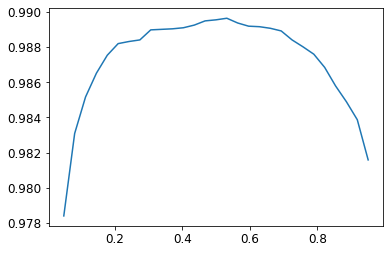

In [37]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

Our multi category model which was trained on single label still return largely just 1 label

#### Test model on non relevant image
With multiple category model, we hope that one benefit is that the model will not force itself to choose from one of the category. Instead, when given non-food images, we expect the model to be able to say: "Nope, there's no chance this is one of the food categories I'm trained to recognize!"

Well let's see. But first, we need to load our previously saved model.

In [8]:
multi_inf = load_learner('/content/gdrive/MyDrive/food11/multicat-model.pkl')

In [9]:
multi_inf.predict('/content/gdrive/MyDrive/food11/grizzly.jpeg')

((#1) ['Meat'],
 TensorBase([False, False, False, False,  True, False, False, False, False, False]),
 TensorBase([1.0301e-02, 2.3329e-01, 5.1406e-03, 5.5430e-03, 6.0496e-01, 4.1444e-04, 3.0896e-04, 3.4687e-02, 2.1218e-03, 1.1991e-02]))

In [10]:
multi_inf.predict('/content/gdrive/MyDrive/food11/cat3.jpeg')

((#0) [],
 TensorBase([False, False, False, False, False, False, False, False, False, False]),
 TensorBase([3.1473e-02, 8.7221e-02, 7.6809e-02, 7.4189e-05, 1.4409e-05, 8.3247e-05, 2.4533e-04, 6.1729e-06, 3.8966e-04, 2.1989e-02]))

In [11]:
multi_inf.predict('/content/gdrive/MyDrive/food11/cat1.png')

((#0) [],
 TensorBase([False, False, False, False, False, False, False, False, False, False]),
 TensorBase([6.9616e-03, 2.1806e-01, 2.0770e-05, 1.7078e-05, 5.1980e-05, 8.1831e-04, 4.1387e-04, 1.0424e-01, 5.3570e-04, 1.4883e-02]))

In [13]:
multi_inf.predict('/content/gdrive/MyDrive/food11/grizzlybear.jpeg')

((#0) [],
 TensorBase([False, False, False, False, False, False, False, False, False, False]),
 TensorBase([0.0901, 0.3419, 0.0135, 0.0028, 0.0573, 0.0010, 0.0004, 0.0172, 0.0122, 0.1310]))

So our model does pretty well on non food photos. Except for the low resolution bear photo. This can probably be improved further if we increase the threshold to 0.5 instead of 0.1 currently